## Machine Learning for Space Applications
### Lab 2


In [1]:
import sys
import ee, geemap, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import random
import ipywidgets as widgets
import importlib
import viz.corine as corine
from importlib import reload as _reload; _ = _reload(corine)
import h3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope


In [2]:
ee.Authenticate()
ee.Initialize()



Successfully saved authorization token.


In [3]:
YEAR = 2021
MAX_PER_CLASS = 250
SEED = 42
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 25
UMAP_MIN_DIST = 0.1
SCALE = 100
SAMPLES_PER_CLASS_RAW = 500
MAX_PER_CLASS_FINAL = 300
MAX_PER_CLASS_TILE = 200
random.seed(SEED); np.random.seed(SEED)

In [28]:
importlib.reload(corine)

region = (ee.FeatureCollection('FAO/GAUL/2015/level1')
          .filter(ee.Filter.eq('ADM1_NAME', 'Mazowieckie'))
          .geometry())

emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2024-01-01','2025-01-01')
       .filterBounds(region)
       .mosaic()
       .clip(region))

m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(emb, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Embeddings 2021')

clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')
m.addLayer(clc_idx, corine.vis, 'CORINE 2018')
legend = m.add_legend(title="CORINE Land Cover 2018", legend_dict=corine.legend_dict)
m

Map(center=[52.34079793776782, 21.102523886969053], controls=(WidgetControl(options=['position', 'transparent_…

In [29]:
aoi_feature = getattr(m, 'user_roi', None) or getattr(m, 'draw_last_feature', None)
if aoi_feature is None:
    raise ValueError("At first - draw polygon")

AOI = aoi_feature.geometry() if hasattr(aoi_feature, 'geometry') else aoi_feature

m.centerObject(AOI, 12)
emb_img = (
    ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
    .filterDate(f'{YEAR}-01-01', f'{YEAR+1}-01-01')
    .filterBounds(AOI)
    .mosaic()
    .clip(AOI)
)

emb_bands = [f"A{i:02d}" for i in range(64)]
emb_img = emb_img.select(emb_bands)
coords = AOI.getInfo()
coords

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[21.018928, 52.459733],
   [21.018928, 52.496954],
   [21.169595, 52.496954],
   [21.169595, 52.459733],
   [21.018928, 52.459733]]]}

In [30]:
clc_raw = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(AOI)


clc_idx = clc_raw.rename('landcover_idx')


mask = clc_idx.gt(0)

emb_masked = emb_img.updateMask(mask)
stack = emb_masked.addBands(clc_idx)


classes_img = clc_idx.updateMask(mask)
present_idx = (
    classes_img
    .reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=AOI,
        scale=SCALE,
        maxPixels=1e9
    )
    .get('landcover_idx')
)

present_idx = ee.Dictionary(present_idx).keys().map(lambda x: ee.Number.parse(x))
present_idx = present_idx.getInfo()
present_idx = sorted(set(int(v) for v in present_idx))
present_idx

[112, 122, 142, 211, 231, 242, 243, 311, 312, 313, 324, 511]

In [31]:
def sample_class(idx):
    img = stack.updateMask(clc_idx.eq(idx))
    return img.sample(
        region=AOI,
        scale=SCALE,
        numPixels=SAMPLES_PER_CLASS_RAW,
        seed=SEED,
        geometries=True,
    )

fc_list = [sample_class(i) for i in present_idx]
samples_fc = ee.FeatureCollection(fc_list).flatten()

fc_dict = samples_fc.getInfo()
features = fc_dict["features"]

rows = []
for f in features:
    props = f["properties"].copy()
    geom = f["geometry"]

    if geom["type"] == "Point":
        lon, lat = geom["coordinates"]
    else:

        coords = np.array(geom["coordinates"][0])
        lon = coords[:, 0].mean()
        lat = coords[:, 1].mean()

    props["longitude"] = lon
    props["latitude"] = lat
    rows.append(props)

df = pd.DataFrame(rows)
df = df.dropna().reset_index(drop=True)

print("Columns in df:", df.columns.tolist())
print(df.head())

Columns in df: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx', 'longitude', 'latitude']
        A00       A01       A02       A03       A04       A05       A06  \
0 -0.062991 -0.267958  0.062991 -0.153787  0.071111 -0.214133 -0.013841   
1 -0.166336 -0.244152 -0.041584 -0.093564  0.003937 -0.310096 -0.066990   
2 -0.108512 -0.310096 -0.093564 -0.160000  0.108512 -0.130165 -0.029773   
3 -0.147697 -0.192910 -0.088827 -0.041584  0.022207 -0.292872  0.032541   
4 -0.108512 -0.251965 -0.048228 -0.166336  0.088827 -0.166336  0.066990   

        A07       A08       A09  ...       

In [32]:
cols = df.columns.tolist()
print("Columns w df:", cols)

lat_col, lon_col = "latitude", "longitude"


if hasattr(h3, "geo_to_h3"):

    def cell_fn(lat, lon, res):
        return h3.geo_to_h3(lat, lon, res)
    def parent_fn(h, res):
        return h3.h3_to_parent(h, res)
else:

    def cell_fn(lat, lon, res):
        return h3.latlng_to_cell(lat, lon, res)
    def parent_fn(h, res):
        return h3.cell_to_parent(h, res)

def latlon_to_h3(row, res):
    return cell_fn(row[lat_col], row[lon_col], res)


df["h3_z6"] = df.apply(lambda r: latlon_to_h3(r, 6), axis=1)


df["h3_z4"] = df["h3_z6"].apply(lambda h: parent_fn(h, 4))

print(df[["landcover_idx", "latitude", "longitude", "h3_z4", "h3_z6"]].head())
print("Number of classes:", df["landcover_idx"].nunique())
print("Classes H3 z4:", df["h3_z4"].nunique())


Columns w df: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx', 'longitude', 'latitude']
   landcover_idx   latitude  longitude            h3_z4            h3_z6
0            112  52.460265  21.032705  841f53dffffffff  861f53d1fffffff
1            112  52.461163  21.024620  841f53dffffffff  861f53d17ffffff
2            112  52.462062  21.033603  841f53dffffffff  861f53d1fffffff
3            112  52.462062  21.038993  841f53dffffffff  861f53d1fffffff
4            112  52.462960  21.026417  841f53dffffffff  861f53d17ffffff
Number of classes: 10
Classes H3 z4: 1


In [12]:
def h3_boundary(lit):
    if hasattr(h3, "h3_to_geo_boundary"):
        boundary = h3.h3_to_geo_boundary(lit, geo_json=True)
        return [[lon, lat] for lat, lon in boundary]

    elif hasattr(h3, "cell_to_boundary"):
        boundary = h3.cell_to_boundary(lit)
        return [[lon, lat] for lat, lon in boundary]

    else:
        raise RuntimeError("wrong version h3")


In [13]:
hex_col_z4 = "h3_z4"
hex_col_z6 = "h3_z6"

unique_hexes_z4 = df[hex_col_z4].unique().tolist()
unique_hexes_z6 = df[hex_col_z6].unique().tolist()

features_z4 = []
for h in unique_hexes_z4:
    coords = h3_boundary(h)
    if coords[0] != coords[-1]:
        coords.append(coords[0])
    geom = ee.Geometry.Polygon([coords])
    feat = ee.Feature(geom, {hex_col_z4: h})
    features_z4.append(feat)

features_z6 = []
for h in unique_hexes_z6:
    coords = h3_boundary(h)
    if coords[0] != coords[-1]:
        coords.append(coords[0])
    geom = ee.Geometry.Polygon([coords])
    feat = ee.Feature(geom, {hex_col_z6: h})
    features_z6.append(feat)

hex_fc_z4 = ee.FeatureCollection(features_z4)
hex_fc_z6 = ee.FeatureCollection(features_z6)

print("Z4 hex:", len(unique_hexes_z4))
print("Z6 hex:", len(unique_hexes_z6))

m_hex = geemap.Map()
m_hex.add_basemap("Esri.WorldImagery")

try:
    m_hex.centerObject(AOI, 9)
except:
    m_hex.centerObject(hex_fc_z4.first().geometry(), 9)

styled_z4 = hex_fc_z4.style(
    color='red',
    fillColor='00000000',
    width=2
)

styled_z6 = hex_fc_z6.style(
    color='yellow',
    fillColor='00000000',
    width=1
)

m_hex.addLayer(styled_z4, {}, "H3 z4")
m_hex.addLayer(styled_z6, {}, "H3 z6 (żółte linie)")
m_hex



Z4 hex: 1
Z6 hex: 5


Map(center=[52.491202055955775, 21.08474449999989], controls=(WidgetControl(options=['position', 'transparent_…

In [14]:
def balance_per_tile(df_in, label_col="landcover_idx", tile_col="h3_z4",
                     max_per_class_tile=200, seed=42):
    parts = []
    for (tile, cls), sub in df_in.groupby([tile_col, label_col]):
        if len(sub) > max_per_class_tile:
            parts.append(sub.sample(max_per_class_tile, random_state=seed))
        else:
            parts.append(sub)
    out = pd.concat(parts, axis=0)
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

df_bal = balance_per_tile(df)
print("Shape after balancing:", df_bal.shape)
print("Classes:", sorted([int(x) for x in df_bal["landcover_idx"].unique()]))


Shape after balancing: (496, 69)
Classes: [112, 122, 142, 211, 231, 242, 243, 311, 312, 511]


In [15]:
emb_cols = [f"A{i:02d}" for i in range(64)]

X = df_bal[emb_cols].values.astype("float32")
y = df_bal["landcover_idx"].values.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)

X_umap = reducer.fit_transform(X)

df_umap = df_bal.copy()
df_umap["umap1"] = X_umap[:, 0]
df_umap["umap2"] = X_umap[:, 1]

df_umap.head()


X shape: (496, 64)
y shape: (496,)
Unique classes: [112 122 142 211 231 242 243 311 312 511]


,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,A61,A62,A63,landcover_idx,longitude,latitude,h3_z6,h3_z4,umap1,umap2
0,-0.079723,-0.199862,-0.179377,-0.147697,-0.022207,-0.041584,0.055363,0.119093,0.059116,0.075356,...,-0.179377,0.055363,0.318893,511,21.060553,52.475536,861f53d1fffffff,841f53dffffffff,17.033556,6.868481
1,-0.098424,-0.276140,-0.019931,-0.276140,0.108512,-0.038447,-0.003014,-0.135886,-0.059116,-0.084214,...,-0.103406,-0.019931,-0.038447,122,21.049773,52.509672,861f53d07ffffff,841f53dffffffff,-3.013474,8.893085
2,-0.172795,-0.147697,-0.135886,-0.228897,0.119093,-0.071111,0.103406,0.019931,-0.012057,0.015748,...,-0.093564,0.013841,0.088827,211,21.055163,52.513266,861f53d07ffffff,841f53dffffffff,-4.099683,10.698291
3,-0.135886,-0.221453,-0.003937,-0.276140,0.079723,-0.119093,0.055363,0.032541,-0.022207,-0.098424,...,-0.084214,0.038447,-0.071111,211,21.018332,52.495299,861f53d17ffffff,841f53dffffffff,-3.417067,9.149130
4,-0.135886,-0.199862,-0.166336,-0.179377,0.088827,-0.098424,0.062991,0.015748,0.007443,-0.051734,...,-0.098424,0.015748,-0.032541,231,21.123435,52.467452,861f53d1fffffff,841f53dffffffff,-4.587326,7.943105


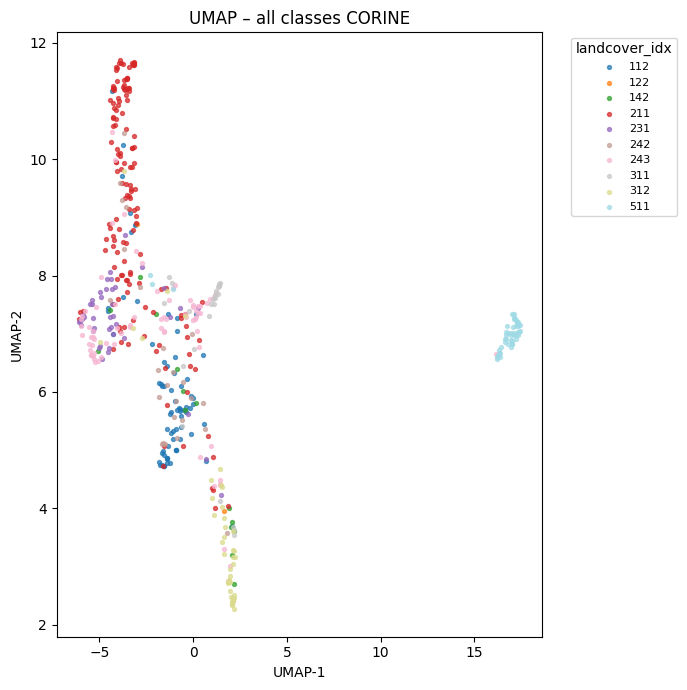

In [16]:
classes = np.sort(df_umap["landcover_idx"].unique())
num_classes = len(classes)
cmap = cm.get_cmap("tab20", num_classes)

plt.figure(figsize=(7, 7))

for i, cls in enumerate(classes):
    m = df_umap["landcover_idx"] == cls
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=8,
        alpha=0.7,
        label=str(int(cls)),
        c=[cmap(i)],
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP – all classes CORINE")
plt.legend(title="landcover_idx", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


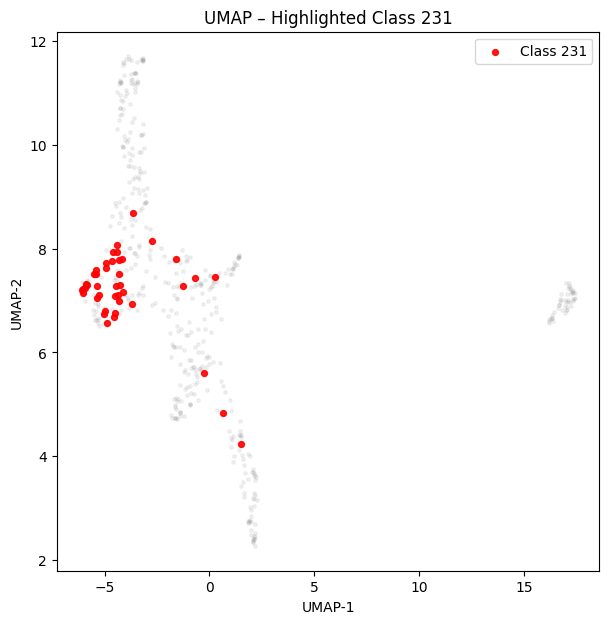

In [17]:
target_class = 231   # choose any class you want to highlight

plt.figure(figsize=(7, 7))

# 1. Plot all other classes with low opacity
mask_other = df_umap["landcover_idx"] != target_class
plt.scatter(
    df_umap.loc[mask_other, "umap1"],
    df_umap.loc[mask_other, "umap2"],
    s=6,
    alpha=0.1,
    color="gray"
)

# 2. Highlight the selected class
mask_target = df_umap["landcover_idx"] == target_class
plt.scatter(
    df_umap.loc[mask_target, "umap1"],
    df_umap.loc[mask_target, "umap2"],
    s=18,
    alpha=0.9,
    color="red",
    label=f"Class {target_class}"
)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title(f"UMAP – Highlighted Class {target_class}")
plt.legend()
plt.show()


Available classes: [112 122 142 211 231 242 243 311 312 511]
Available classes: [112, 122, 142]


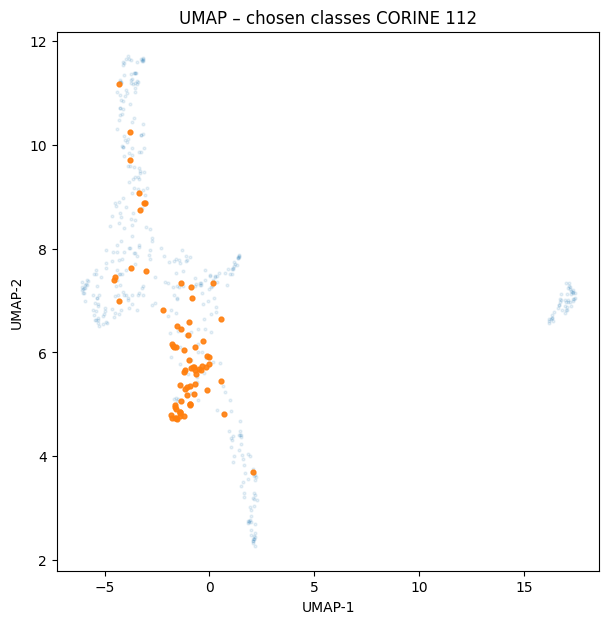

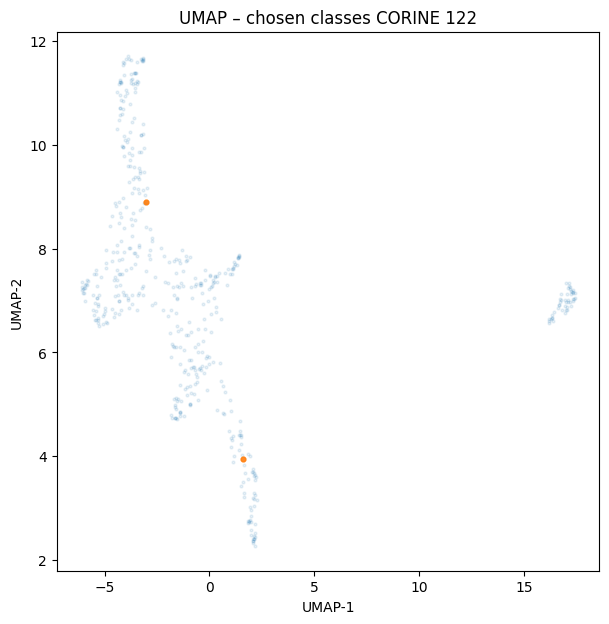

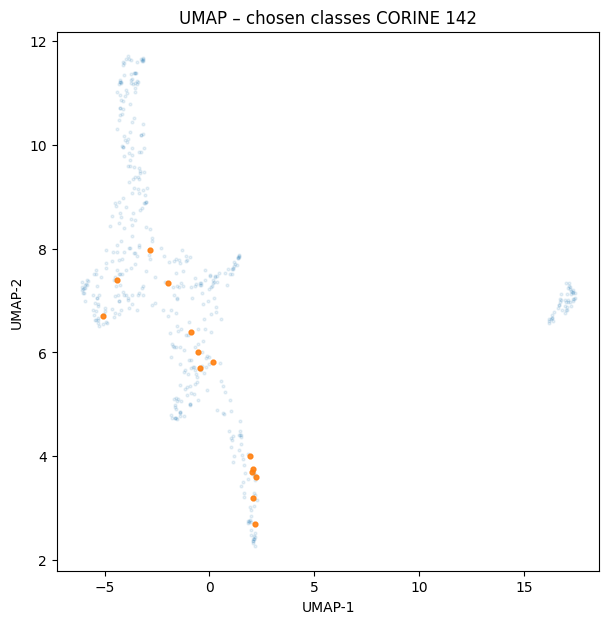

In [18]:
print("Available classes:", classes)

focus_classes = [int(classes[0]), int(classes[1]), int(classes[2])]
print("Available classes:", focus_classes)

for cls in focus_classes:
    m_focus = df_umap["landcover_idx"] == cls

    plt.figure(figsize=(7, 7))


    plt.scatter(
        df_umap.loc[~m_focus, "umap1"],
        df_umap.loc[~m_focus, "umap2"],
        s=4,
        alpha=0.1,
    )


    plt.scatter(
        df_umap.loc[m_focus, "umap1"],
        df_umap.loc[m_focus, "umap2"],
        s=12,
        alpha=0.9,
    )

    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(f"UMAP – chosen classes CORINE {cls}")
    plt.show()


In [19]:
def get_class_umap(cls):
    mask = df_umap["landcover_idx"] == cls
    Xc = df_umap.loc[mask, ["umap1", "umap2"]].values
    return Xc, mask

def plot_outliers(cls, mask, outlier_mask, title):
    plt.figure(figsize=(7, 7))


    plt.scatter(
        df_umap.loc[~mask, "umap1"],
        df_umap.loc[~mask, "umap2"],
        s=3,
        alpha=0.05,
    )

    Xc = df_umap.loc[mask, ["umap1", "umap2"]].values

    plt.scatter(
        Xc[~outlier_mask, 0],
        Xc[~outlier_mask, 1],
        s=12,
        alpha=0.6,
    )

    plt.scatter(
        Xc[outlier_mask, 0],
        Xc[outlier_mask, 1],
        s=40,
        alpha=0.95,
        marker="x",
    )

    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(f"{title} – class {cls}")
    plt.show()

print("Available classes:", classes)
target_classes =  [int(classes[0]), int(classes[1]), int(classes[2])]
target_classes


Available classes: [112 122 142 211 231 242 243 311 312 511]


[112, 122, 142]

In [20]:
def show_all_detectors_for_class(cls, contamination=0.05):
    Xc, mask = get_class_umap(cls)

    rc = EllipticEnvelope(contamination=contamination, random_state=42)
    rc.fit(Xc)
    out_rc = (rc.predict(Xc) == -1)

    svm = OneClassSVM(kernel="rbf", gamma="scale", nu=contamination)
    svm.fit(Xc)
    out_svm = (svm.predict(Xc) == -1)

    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=contamination,
        novelty=False,
    )
    out_lof = (lof.fit_predict(Xc) == -1)

    methods = {
        "Robust Covariance": out_rc,
        "One-Class SVM": out_svm,
        "LOF": out_lof,
    }

    X_all = df_umap[["umap1", "umap2"]].values
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

    for ax, (name, outliers) in zip(axes, methods.items()):
        ax.scatter(
            df_umap.loc[~mask, "umap1"],
            df_umap.loc[~mask, "umap2"],
            s=3,
            alpha=0.05,
        )
        ax.scatter(
            Xc[~outliers, 0],
            Xc[~outliers, 1],
            s=12,
            alpha=0.6,
        )
        ax.scatter(
            Xc[outliers, 0],
            Xc[outliers, 1],
            s=40,
            alpha=0.95,
            marker="x",
        )
        ax.set_title(name)
        ax.set_xlabel("UMAP-1")
        ax.set_ylabel("UMAP-2")

    fig.suptitle(f"Class {cls} – classificators summary", fontsize=14)
    plt.tight_layout()
    plt.show()


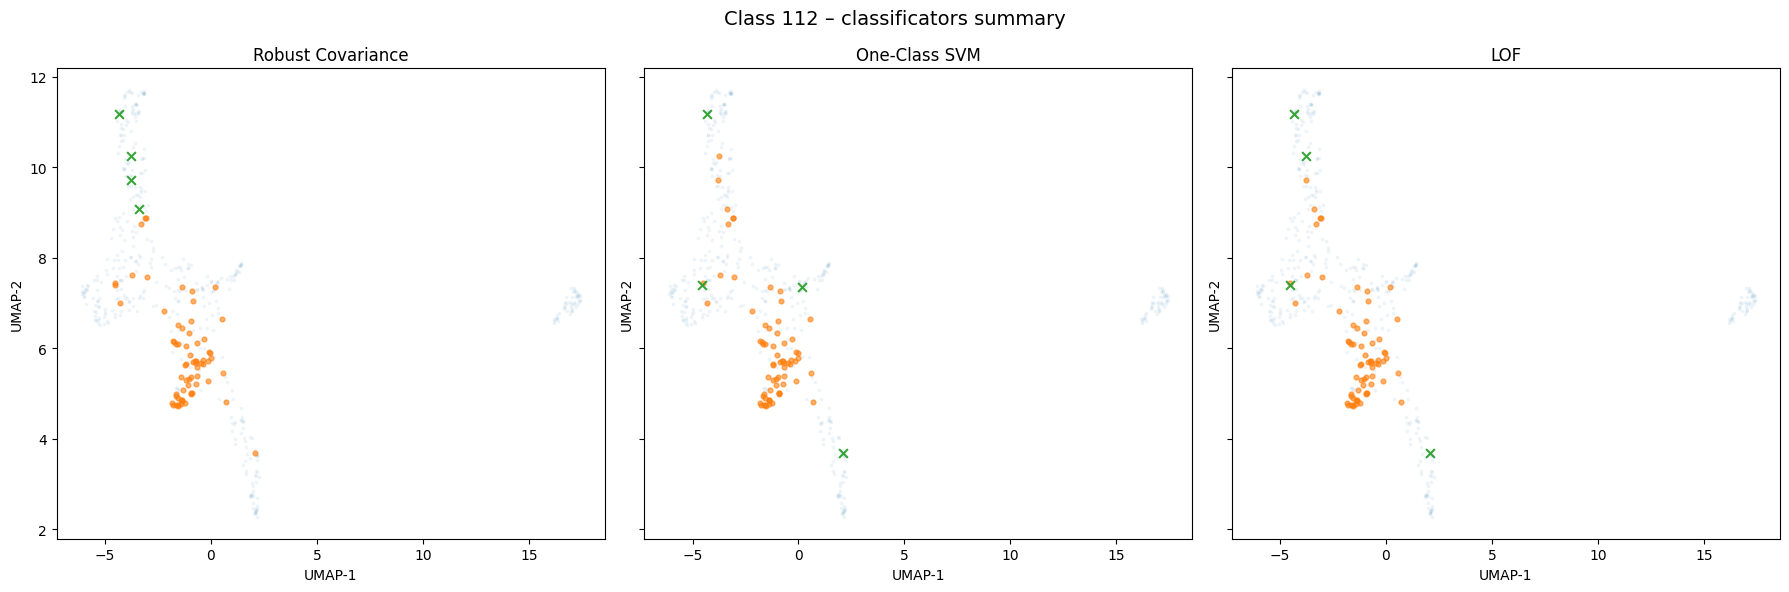

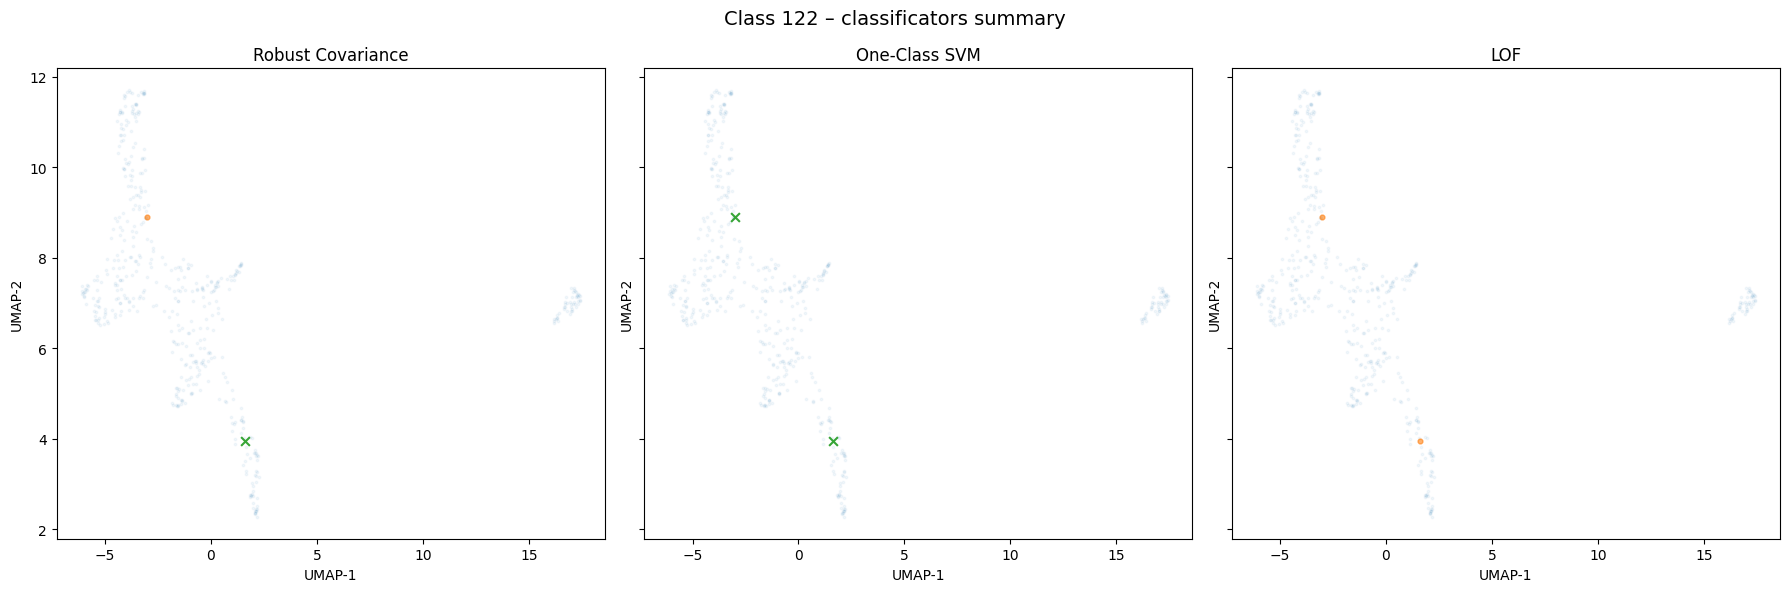

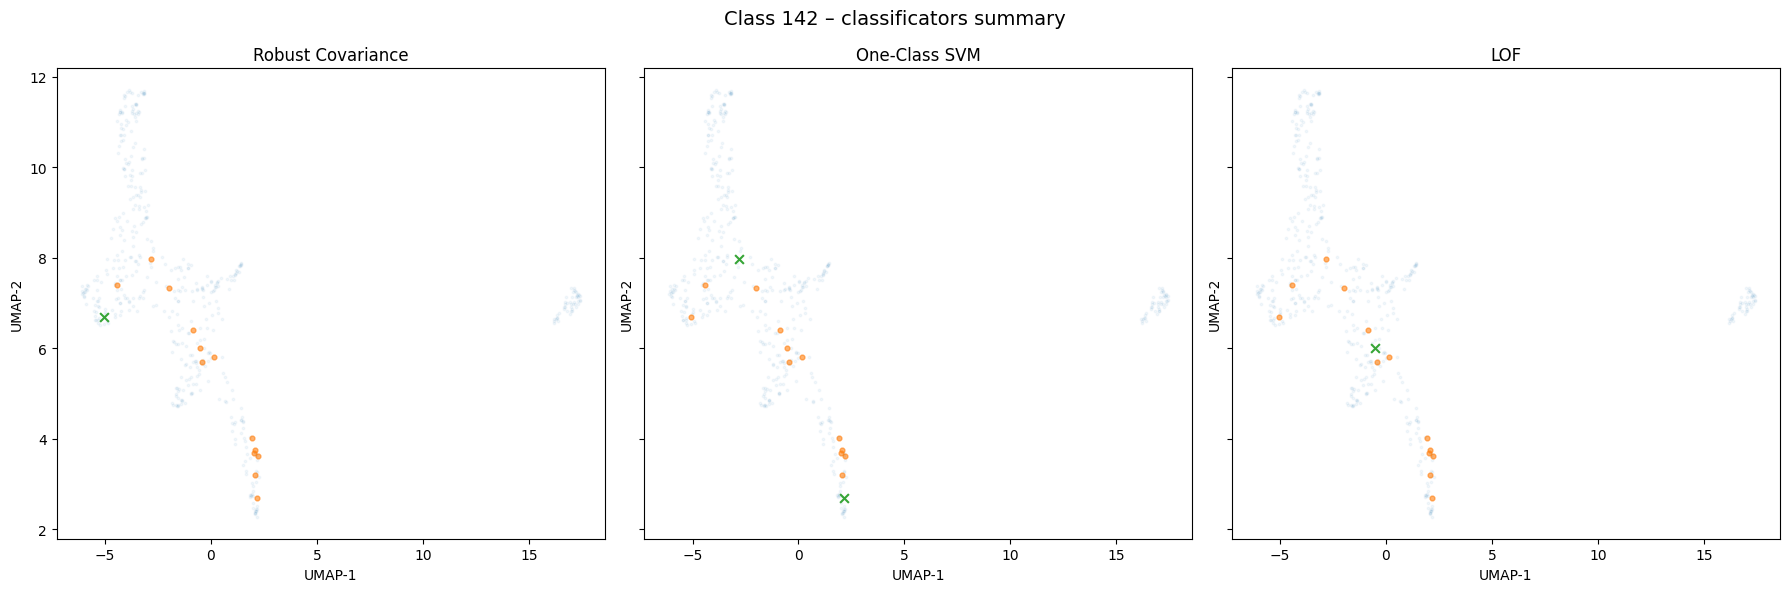

In [21]:
for cls in focus_classes:
    show_all_detectors_for_class(cls)


In [22]:
df_umap["is_outlier_rc"] = False
contamination = 0.05

for cls in classes:
    Xc, mask = get_class_umap(cls)

    if Xc.shape[0] < 2:
        print(f"Class {cls}: too few samples ({Xc.shape[0]}), skipping RC.")
        continue

    rc = EllipticEnvelope(contamination=contamination, random_state=42)
    rc.fit(Xc)

    pred = rc.predict(Xc)
    outliers = (pred == -1)

    df_umap.loc[mask, "is_outlier_rc"] = outliers

df_umap["is_outlier_rc"] = df_umap["is_outlier_rc"].astype(bool)
df_umap["is_outlier_rc"].value_counts()


is_outlier_rc
False    465
True      31
Name: count, dtype: int64

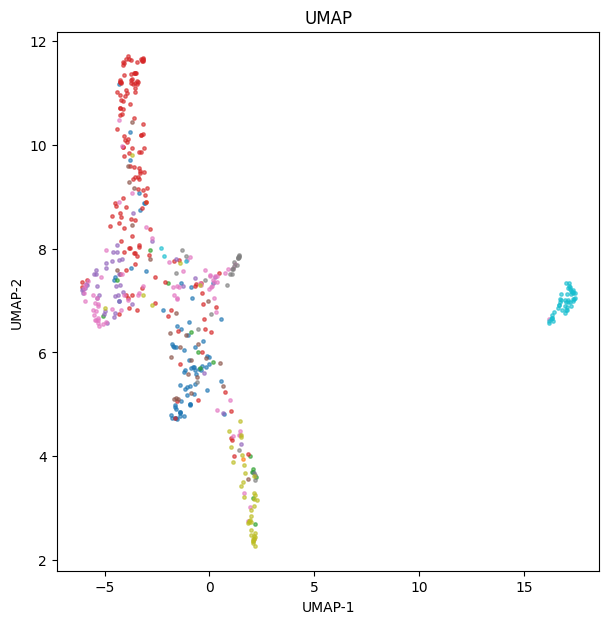

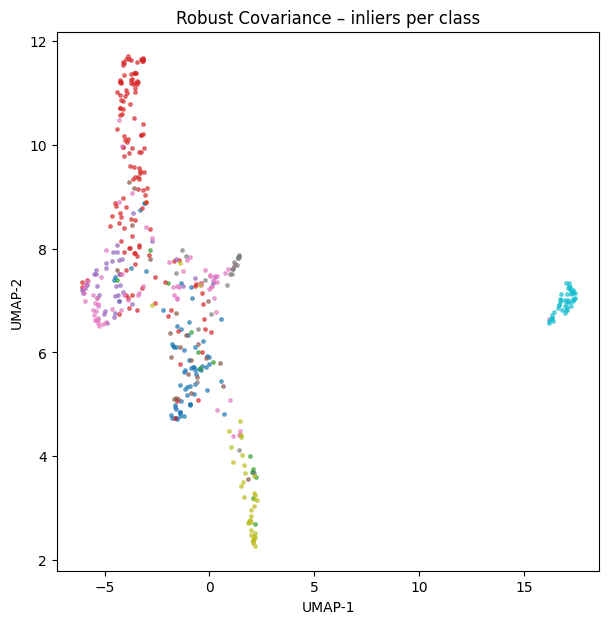

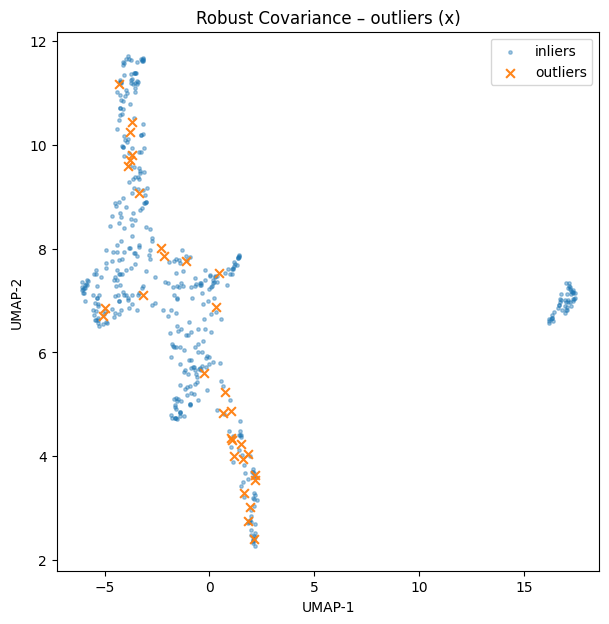

In [23]:
plt.figure(figsize=(7, 7))
for cls in classes:
    m = df_umap["landcover_idx"] == cls
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=6,
        alpha=0.6,
    )
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP")
plt.show()

plt.figure(figsize=(7, 7))
for cls in classes:
    m = (df_umap["landcover_idx"] == cls) & (~df_umap["is_outlier_rc"])
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=6,
        alpha=0.6,
    )
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Robust Covariance – inliers per class")
plt.show()

plt.figure(figsize=(7, 7))

m_in = ~df_umap["is_outlier_rc"]
plt.scatter(
    df_umap.loc[m_in, "umap1"],
    df_umap.loc[m_in, "umap2"],
    s=6,
    alpha=0.4,
    label="inliers",
)

m_out = df_umap["is_outlier_rc"]
plt.scatter(
    df_umap.loc[m_out, "umap1"],
    df_umap.loc[m_out, "umap2"],
    s=40,
    alpha=0.95,
    marker="x",
    label="outliers",
)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Robust Covariance – outliers (x)")
plt.legend()
plt.show()


In [24]:
def run_lab2():
    """
    Runs Habitat-PL Lab 2:
    - sampling
    - dimensionality reduction
    - outlier detection
    """
    return {
        "df_umap": df_umap,
        "emb_img": emb_img,
        "AOI": AOI,
        "SCALE": SCALE
    }
